In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from io import BytesIO
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.utils import make_grid
import tempfile

# source of the function: 
# pytorch.org/vision/stable/auto_examples/others/plot_visualization_utils.html
def show(imgs): 
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

pd.set_option('display.max_columns', None)

dvojice = [[2, 8], [3, 9], [8, 12], [9, 12], [3, 2], [13, 12], [8, 12], [9, 12],
            [7, 8], [10, 9], [6, 7], [11, 10], [3, 2], [4, 3], [5, 4], [1, 2], [0, 1]]

In [2]:
class Set():

    def __init__(self, DR, HM, keypoints, labels):
        self.DR = DR
        self.HM = HM
        self.keypoints = keypoints
        self.labels = labels

    def visualise(self, i: int, method: str):
        if method == "dr":
            pred = self.DR
        elif method == "hm":
            pred = self.HM
        else:
            raise ValueError("Method must be either 'hm' or 'dr'")

        imgI = self.labels.iloc[i]["Unnamed: 0"]
        imgLoc = self.labels.loc[self.labels["Unnamed: 0"] == imgI]["img"].iloc[0]
        print("Image path:", imgLoc)
        predPoseArray = pred[i]
        poseArray = self.keypoints[i]

        _, ax = plt.subplots()

        im = Image.open("/mnt/nfs-data/public/xkristof/" + imgLoc)
        ax.imshow(im)

        for dvojica in dvojice:
            if poseArray[dvojica[0]][2] != 0 and poseArray[dvojica[1]][2] != 0:
                x1, y1 = [poseArray[dvojica[0]][0] * 128, poseArray[dvojica[1]][0] * 128], [poseArray[dvojica[0]][1] * 128, poseArray[dvojica[1]][1] * 128]
                plt.plot(x1, y1, marker = 'o', color="limegreen")

        for dvojica in dvojice:
            if predPoseArray[dvojica[0]][2] != 0 and predPoseArray[dvojica[1]][2] != 0:
                x1, y1 = [predPoseArray[dvojica[0]][0] * 128, predPoseArray[dvojica[1]][0] * 128], [predPoseArray[dvojica[0]][1] * 128, predPoseArray[dvojica[1]][1] * 128]
                plt.plot(x1, y1, marker = 'o', color="r")

        for keypoint in poseArray:
            colour = "limegreen"
            if keypoint[2] == 0: # if not visible then darkgreen
                colour = "g"
            circ = patches.CirclePolygon((keypoint[0] * 128, keypoint[1] * 128), 1, color=colour)
            ax.add_patch(circ)

        for keypoint in predPoseArray:
            colour = "red"
            if keypoint[2] == 0: # if not visible then darkgreen
                colour = "darkred"
            circ = patches.CirclePolygon((keypoint[0] * 128, keypoint[1] * 128), 1, color=colour)
            ax.add_patch(circ)

        plt.axis('off')

        buffer = BytesIO()
        plt.savefig(buffer, format='jpg', bbox_inches='tight', pad_inches=0)

        plt.clf() # clearing the plt so that it wont be shown twice

        tempFile = tempfile.NamedTemporaryFile(delete=False)
        tempFile.write(buffer.getvalue())
        tempFileLocation = tempFile.name
        tempFile.close()
        tensorImg = read_image(tempFileLocation)

        ImgList = list(tensorImg)
        grid = make_grid(ImgList)
        show(grid)
        

In [3]:
def getData():
    DR = np.load("/mnt/nfs-data/public/xkristof/newdrconvnext_base0.npy")
    HM = np.load("/mnt/nfs-data/public/xkristof/newhmconvnext_large0.npy")
    keypoints = np.load("/mnt/nfs-data/public/xkristof/keypoints.npy")
    labels = pd.read_csv("/mnt/nfs-data/public/xkristof/labels.csv")
    labels_val = pd.read_csv("/mnt/nfs-data/public/xkristof/labels_val.csv")
    DR_val_list = list()
    HM_val_list = list()
    keypoints_val_list = list()
    for i in range(len(labels_val)):
        inde = labels_val.iloc[i]["Unnamed: 0"]
        DR_val_list.append(DR[inde])
        HM_val_list.append(HM[inde])
        keypoints_val_list.append(keypoints[inde])
    DR_val = np.array(DR_val_list)
    HM_val = np.array(HM_val_list)
    keypoints_val = np.array(keypoints_val_list)
    DR_val = DR_val.astype("float64")
    HM_val = HM_val.astype("float64")

    return Set(DR, HM, keypoints, labels), Set(DR_val, HM_val, keypoints_val, labels_val)

In [4]:
allSet, valSet = getData()

Image path: 003XXX/003494.jpg


<Figure size 640x480 with 0 Axes>

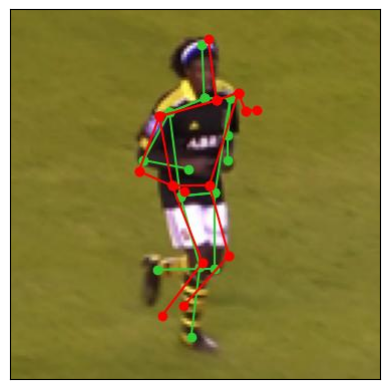

In [7]:
#in valSet only validation pictures are visualised
valSet.visualise(7590, "dr") # from 0 to 7590 

Image path: 005XXX/005878.jpg


<Figure size 640x480 with 0 Axes>

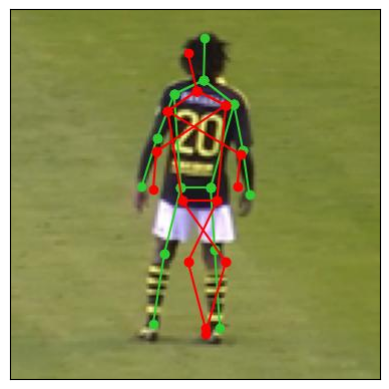

In [8]:
allSet.visualise(5878, "hm")  # in allSet all pictures are visualised (including training pictures)